# **Section 3: Form a portfolio, data selection, and necessary transformation**

In [911]:
import pandas as pd
import yfinance as yf
import numpy as np
from statsmodels.tsa.stattools import adfuller
from portfolio import *

## Part 1 - Creating portfolio

In [912]:
tickers = [
    'AAPL', 'MSFT',                                   # Information Technology
    'BIIB', 'JNJ', 'LLY', 'MRK', 'PFE',               # Health Care
    'AMZN', 'NKE',                                    # Consumer Discretionary
    'JPM', 'BAC', 'C', 'MS',                          # Financials
    'GOOGL',                                          # Communication Services
    'HON', 'UNP',                                     # Industrials
    'PG', 'KO', 'WMT', 'CL', 'TSN',                   # Consumer Staples
    'XOM', 'CVX',                                     # Energy
    'NEE',                                            # Utilities
    'PLD', 'AMT',                                     # Real Estate
    'LIN'                                             # Materials
]

equal_weight = 1/len(tickers)
weights = {ticker:equal_weight for ticker in tickers}
prices = yf.download(tickers, start='1976-04-01', end='2023-10-01', interval='1mo', progress=False)['Adj Close']

## Part 2 - Clean data

In [913]:
prices.index = pd.to_datetime(prices.index)
prices.index = prices.index.strftime('%Y-%m')
prices.dropna(inplace=True)
prices.head()

Ticker,AAPL,AMT,AMZN,BAC,BIIB,C,CL,CVX,GOOGL,HON,...,MSFT,NEE,NKE,PFE,PG,PLD,TSN,UNP,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2004-09,0.583704,11.720682,2.0430,27.297630,61.169998,278.599121,14.123345,25.307074,3.235232,21.670815,...,17.250332,4.690567,7.723267,12.824567,30.943272,18.852247,11.653692,9.766549,11.790461,24.749006
2004-10,0.789319,13.125641,1.7065,28.502581,58.160000,280.177765,13.948286,25.033415,4.758987,20.353401,...,17.449974,4.730387,7.979590,12.133054,29.262312,19.096682,10.547976,10.549774,11.950030,25.204750
2004-11,1.009997,13.843386,1.9840,29.444389,58.680000,285.172729,14.453044,25.759989,4.542805,21.350525,...,16.726263,4.828564,8.308353,11.638510,30.722250,20.580606,11.922846,10.628518,11.537813,26.244287
2004-12,0.970079,14.049547,2.2145,29.902576,66.610001,307.030640,16.077791,24.962439,4.812658,21.512024,...,18.579523,5.180115,8.900123,11.337540,31.641394,20.807276,13.417188,11.266829,11.706242,26.391439
2005-01,1.158371,13.835746,2.1610,29.797825,64.959999,312.574890,16.511477,25.860912,4.883303,21.858309,...,18.273581,5.311088,8.513955,10.186502,30.578644,19.383282,12.520278,10.032345,11.641441,26.566496


## Part 4 - Stationarity tests on MEVs

In [914]:
MEVs = pd.read_csv('2024-Table_2A_Historic_Domestic.csv')
quarter_to_month = {'Q1': '03', 'Q2': '06', 'Q3': '09', 'Q4': '12'}

def convert_to_yyyy_mm(quarter_str):
    year, quarter = quarter_str.split()
    month = quarter_to_month[quarter]
    return f"{year}-{month}"
    
MEVs['Date'] = MEVs['Date'].apply(convert_to_yyyy_mm)
MEVs.set_index('Date', inplace=True)
MEVs.drop(columns=['Scenario Name'], inplace=True)

MEVs.head()

,Real GDP growth,Nominal GDP growth,Real disposable income growth,Nominal disposable income growth,Unemployment rate,CPI inflation rate,3-month Treasury rate,5-year Treasury yield,10-year Treasury yield,BBB corporate yield,Mortgage rate,Prime rate,Dow Jones Total Stock Market Index (Level),House Price Index (Level),Commercial Real Estate Price Index (Level),Market Volatility Index (Level)
Date,,,,,,,,,,,,,,,,
1976-03,9.3,14.0,5.0,9.6,7.7,4.7,4.9,7.4,7.6,NaN,8.9,6.8,NaN,22.9,50.9,NaN
1976-06,3.0,7.2,2.3,5.8,7.6,3.6,5.2,7.4,7.6,NaN,8.8,6.9,NaN,23.6,51.8,NaN
1976-09,2.2,7.6,3.2,9.6,7.7,6.5,5.2,7.3,7.6,NaN,9.0,7.1,NaN,24.2,52.6,NaN
1976-12,2.9,10.5,2.6,9.2,7.8,5.9,4.7,6.5,7.1,NaN,8.8,6.5,NaN,25.2,53.4,NaN
1977-03,4.8,11.7,0.9,8.4,7.5,7.5,4.6,6.8,7.2,NaN,8.7,6.3,NaN,26.2,55.0,NaN


In [915]:
def make_stationary(series, significance_level=0.05):
    """
    Differentiates a pandas Series until it becomes stationary based on the Augmented Dickey-Fuller test.
    
    Parameters:
    - series: pd.Series - The time series data to test for stationarity.
    - significance_level: float - The p-value threshold to consider the series stationary (default is 0.05).
    
    Returns:
    - num_diffs: int - The number of differences needed to achieve stationarity.
    """
    num_diffs = 0
    diff_series = series.copy()
    
    while True:

        adf_test = adfuller(diff_series.dropna())
        p_value = adf_test[1]
        
        if p_value < significance_level:
            return num_diffs, diff_series
        
        diff_series = diff_series.diff().dropna()
        num_diffs += 1


In [916]:
diffs_needed = pd.DataFrame(index=MEVs.columns, columns=['Differences'])
for MEV in MEVs.columns:
    stationary = make_stationary(MEVs[MEV])
    diffs_needed.loc[MEV] = stationary[0]
    if stationary[0] != 0:
        MEVs[MEV] = stationary[1]
MEVs = MEVs.dropna()
MEVs.head()

,Real GDP growth,Nominal GDP growth,Real disposable income growth,Nominal disposable income growth,Unemployment rate,CPI inflation rate,3-month Treasury rate,5-year Treasury yield,10-year Treasury yield,BBB corporate yield,Mortgage rate,Prime rate,Dow Jones Total Stock Market Index (Level),House Price Index (Level),Commercial Real Estate Price Index (Level),Market Volatility Index (Level)
Date,,,,,,,,,,,,,,,,
1990-03,4.4,9.0,3.3,2.6,5.3,3.0,0.1,0.5,0.5,0.6,0.3,-0.5,-146.4,1.1,-1.0,27.3
1990-06,1.5,6.1,3.0,-2.6,5.3,-3.1,-0.1,0.2,0.3,0.3,0.2,0.0,150.9,0.0,-0.9,24.2
1990-09,0.3,3.7,0.1,-1.6,5.7,3.1,-0.2,-0.2,0.0,-0.1,-0.2,0.0,-545.1,-0.1,-0.5,36.5
1990-12,-3.6,-0.7,-3.2,-3.1,6.1,-0.1,-0.5,-0.4,-0.3,0.3,-0.1,0.0,222.1,-0.4,-0.4,34.0
1991-03,-1.9,2.0,1.2,1.3,6.6,-4.0,-1.0,-0.4,-0.3,-0.5,-0.5,-0.8,482.3,-0.6,-1.0,36.2


In [917]:
diffs_needed[diffs_needed['Differences']!=0]

,Differences
Nominal disposable income growth,1
CPI inflation rate,1
3-month Treasury rate,1
5-year Treasury yield,1
10-year Treasury yield,1
BBB corporate yield,1
Mortgage rate,1
Prime rate,1
Dow Jones Total Stock Market Index (Level),1
House Price Index (Level),1


## Part 5 - Summary Statistics

### For the stock returns:

In [918]:
prices.describe().T

,count,mean,std,min,25%,50%,75%,max
Ticker,,,,,,,,
AAPL,229.0,41.089456,51.693559,0.583704,5.583981,19.840919,45.121765,194.971771
AMT,229.0,93.712151,73.646327,11.720682,32.260506,65.349609,142.240723,267.634796
AMZN,229.0,45.629840,53.076733,1.344500,4.528000,16.122000,85.936501,175.353500
BAC,229.0,21.329719,10.299661,3.136745,12.113330,21.554995,29.444389,44.192059
BIIB,229.0,188.913712,115.398784,34.450001,57.389999,219.289993,289.730011,422.239990
C,229.0,94.389898,107.034427,11.438827,35.938484,43.804790,61.727089,384.072052
CL,229.0,45.405716,19.576114,13.948286,26.109663,50.561005,61.057652,79.470909
CVX,229.0,70.391148,32.970923,24.891184,43.791641,69.687378,85.466721,169.508759
GOOGL,229.0,40.853445,37.465174,3.235232,12.862294,26.935305,56.320042,147.680313


### The stock prices range from October of 2004 up to October of 2023 on a monthly basis.

### For the MEVs:

In [919]:
MEVs.describe().T

,count,mean,std,min,25%,50%,75%,max
Real GDP growth,136.0,2.541912,4.532672,-28.0,1.475,2.55,4.025,34.8
Nominal GDP growth,136.0,4.873529,5.098456,-29.2,3.600,5.00,6.500,39.7
Real disposable income growth,136.0,2.811029,7.538795,-27.6,1.200,2.75,4.225,56.0
Nominal disposable income growth,136.0,-0.017647,12.432013,-86.6,-1.925,0.20,2.000,69.3
Unemployment rate,136.0,5.758088,1.742946,3.5,4.475,5.40,6.700,13.0
CPI inflation rate,136.0,-0.009559,2.423462,-15.2,-1.200,0.00,1.025,8.4
3-month Treasury rate,136.0,-0.017647,0.426334,-1.3,-0.100,0.00,0.200,1.6
5-year Treasury yield,136.0,-0.025735,0.415977,-1.1,-0.300,0.00,0.200,1.2
10-year Treasury yield,136.0,-0.025735,0.368178,-0.9,-0.300,0.00,0.200,1.0
BBB corporate yield,136.0,-0.026471,0.484613,-1.6,-0.300,0.00,0.225,2.6


### The MEVs range from Q1 of 1990 to Q3 of 2023. Chances are in the data analysis where the MEVs are used, the years that are in this dataset preceding those in the stock returns dataset will be dropped.

## **Section 4: Stress Testing using Fama-French three-factor model**

## Part 1 - Picking a subset of MEVs

### We're going to try and capture the big economic picture at each time step while avoiding redundancy. In order to do this, we chose to use the CPI, real GDP growth, real disposable income growth, 3 month, 5 year, and 10 year rates.

In [920]:
MEVs = MEVs[['Real GDP growth', 
             'Real disposable income growth', 
             'CPI inflation rate', 
             '3-month Treasury rate',
             '5-year Treasury yield',
             '10-year Treasury yield',
             'Market Volatility Index (Level)'
            ]]

## Part 2 - Report the results from the Fama-French three factor model

In [921]:
# portfolio returns

returns = prices.pct_change()[1:]
returns['portfolio'] = sum(returns[stock] * weights[stock] for stock, weight in weights.items()) # Setting the portfolio returns based on weights

In [922]:
# import FF factors

FF_factors = pd.read_excel('wrds_data.xlsx', sheet_name='returns', index_col=0)
FF_factors = FF_factors[['FAMA-FRENCH MARKET FACTOR', 'RISK-FREE RATE', 'FAMA-FRENCH SIZE FACTOR (SMB)', 'FAMA-FRENCH VALUE FACTOR (HML)', 'MOMENTUM FACTOR']]
FF_factors = FF_factors.rename(columns={'FAMA-FRENCH MARKET FACTOR': 'MKT', 'RISK-FREE RATE': 'RF','FAMA-FRENCH SIZE FACTOR (SMB)': 'SMB', 'FAMA-FRENCH VALUE FACTOR (HML)': 'HML', 'MOMENTUM FACTOR': 'UMD'})
FF_factors['MKT'] = FF_factors['MKT'] - FF_factors['RF']
FF_factors = FF_factors.drop(columns=['RF'])


/opt/anaconda3/envs/finm/lib/python3.12/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [923]:
# get FF factors and portfolio returns in one dataframe

FF_model = FF_factors.copy()
FF_model['portfolio'] = returns['portfolio']
FF_model = FF_model.dropna()

In [924]:
# Regress portfolio returns on FF factors

import statsmodels.api as sm

X = FF_model[['MKT', 'SMB', 'HML']]
X = sm.add_constant(X)
Y = FF_model['portfolio']
ffmodel = sm.OLS(Y, X).fit()

# print results

print("FF3 model R^2:", ffmodel.rsquared)
ffmodel_regression_summary = pd.DataFrame([ffmodel.params, ffmodel.tvalues], index=['Betas', 't-values']).T
ffmodel_regression_summary

FF3 model R^2: 0.9009727056574445


,Betas,t-values
const,0.005922,6.581785
MKT,0.917861,43.148310
SMB,-0.269474,-6.918557
HML,0.103592,3.700917


## The Fama-French model for our portfolio is given by: 
$$
\Huge
E[r_i] = 0.005 + 0.92(MKT - r_f) - 0.27(SMB) + 0.10(HML)
$$

## Part 3 - Identify the impact of our chosen MEVs on Fama-French factors.

In [925]:
# Adjust FF monthly returns to quarterly returns

FF_factors.reset_index(inplace=True)

# Extract quarter and aggregate the data
FF_factors['Date'] = pd.to_datetime(FF_factors['Date'])
FF_factors['Quarter'] = FF_factors['Date'].dt.to_period('Q')

# Calculate cumulative returns for each FF portfolio within each quarter
# Assuming monthly returns are given as percentages, so convert to decimals for compounding
FF_factors['MKT'] = FF_factors['MKT'] /100 + 1
FF_factors['SMB'] = FF_factors['SMB'] /100 + 1
FF_factors['HML'] = FF_factors['HML'] /100  + 1
FF_factors['UMD'] = FF_factors['UMD'] /100  + 1


# Aggregate cumulative returns by quarter using product to compound
quarterly_returns = FF_factors.groupby('Quarter').agg({
    'MKT': 'prod',
    'SMB': 'prod',
    'HML': 'prod'
}).reset_index()

# Convert back to percentage returns
quarterly_returns[['MKT', 'SMB', 'HML']] = (quarterly_returns[['MKT', 'SMB', 'HML']] - 1) * 100

quarterly_returns = quarterly_returns.set_index('Quarter')
quarterly_returns = quarterly_returns['1990':]

In [926]:
# Prepare MEV dataframe for regression

MEVs.index = pd.to_datetime(MEVs.index)
MEVs = MEVs['1990':]
MEVs = MEVs[:(len(quarterly_returns))]
quarterly_returns.index = MEVs.index


In [927]:
# Merge FF data and MEV data into one dataframe

FF_MEVs = MEVs.merge(quarterly_returns, left_index=True, right_index=True, how='inner')

In [928]:
# Regress FF factors on MEVs

import statsmodels.api as sm

reg_models = []
factors = ['MKT', 'SMB', 'HML']
for factor in factors:
    model = sm.OLS(FF_MEVs[factor], sm.add_constant(FF_MEVs[['Real GDP growth', 'Real disposable income growth', 'CPI inflation rate', '3-month Treasury rate', '5-year Treasury yield', '10-year Treasury yield', 'Market Volatility Index (Level)']])).fit()
    reg_models.append(model)

mkt_model = reg_models[0]
smb_model = reg_models[1]
hml_model = reg_models[2]

# print results
print("MKT regression R^2:", mkt_model.rsquared)
print("SMB regression R^2:", smb_model.rsquared)
print("HML regression R^2:", hml_model.rsquared)

regression_summary = pd.DataFrame([mkt_model.params, mkt_model.tvalues, smb_model.params, smb_model.tvalues, hml_model.params, hml_model.tvalues], index=['MKT betas', 'MKT t-values', 'SMB betas', 'SMB t-values', 'HML betas', 'HML t-values']).T
regression_summary

MKT regression R^2: 0.14263072847689473
SMB regression R^2: 0.11015041676196358
HML regression R^2: 0.06919291678570594


,MKT betas,MKT t-values,SMB betas,SMB t-values,HML betas,HML t-values
const,0.080817,3.793438,0.015154,1.210375,0.040483,2.304782
Real GDP growth,0.001304,0.704501,-0.000053,-0.048413,-0.000869,-0.569436
Real disposable income growth,0.001254,1.260938,0.001057,1.808561,0.000391,0.476301
CPI inflation rate,0.000137,0.043468,-0.000507,-0.273913,0.000883,0.339837
3-month Treasury rate,-0.024945,-1.147650,-0.032754,-2.564200,-0.000053,-0.002979
5-year Treasury yield,0.009721,0.178545,0.013965,0.436459,-0.007787,-0.173463
10-year Treasury yield,-0.006217,-0.110846,0.021363,0.648165,0.030040,0.649655
Market Volatility Index (Level),-0.002717,-4.049941,-0.000553,-1.402945,-0.001277,-2.308983


### This dataframe shows the coefficients of the linear regressions:
$$
\Huge
FF_i = \alpha_i + \beta_{1_i}MEV_1 + \beta_2MEV_2 + \ldots + \beta_nMEV_n
$$

## Part 4 - Investigating the impact of the MEVs on Fama-French factors during *stressed times*

### We are picking all date ranges of stressed times after 1976, where our data for FF factors and MEVs starts. This gives a full picture on the effect of the MEVs on the FF factors throughout history of the past ~5 decades, whereas a smaller sample size wouldn't accurately describe the effects.

In [929]:
# identify stress periods, subset FF_MEV data for stress periods, and regress FF factors on MEVs for stress periods

stressed_date_ranges = [('1990-09', '1991-03'),
                        ('2001-03', '2001-12'),
                        ('2007-12', '2009-06'),
                        ('2019-12', '2020-06')
                       ]

stressed_data = pd.concat(
    [FF_MEVs.loc[start:end] for start, end in stressed_date_ranges]
)

stressed_reg_models = []
factors = ['MKT', 'SMB', 'HML']
for factor in factors:
    model = sm.OLS(stressed_data[factor], sm.add_constant(stressed_data[['Real GDP growth', 'Real disposable income growth', 'CPI inflation rate', '3-month Treasury rate', '5-year Treasury yield', '10-year Treasury yield', 'Market Volatility Index (Level)']])).fit()
    stressed_reg_models.append(model)

stressed_mkt_model = stressed_reg_models[0]
stressed_smb_model = stressed_reg_models[1]
stressed_hml_model = stressed_reg_models[2]

# print results
print("stressed MKT regression R^2:", stressed_mkt_model.rsquared)
print("stressed SMB regression R^2:", stressed_smb_model.rsquared)
print("stressed HML regression R^2:", stressed_hml_model.rsquared)

regression_summary = pd.DataFrame([stressed_mkt_model.params, stressed_mkt_model.tvalues, stressed_smb_model.params, stressed_smb_model.tvalues, stressed_hml_model.params, stressed_hml_model.tvalues], index=['stressed MKT betas', 'stressed MKT t-values', 'stressed SMB betas', 'stressed SMB t-values', 'stressed HML betas', 'stressed HML t-values']).T
regression_summary

stressed MKT regression R^2: 0.7023307703084825
stressed SMB regression R^2: 0.7176019746831155
stressed HML regression R^2: 0.47235510302680994


,stressed MKT betas,stressed MKT t-values,stressed SMB betas,stressed SMB t-values,stressed HML betas,stressed HML t-values
const,0.130738,0.937940,-0.001516,-0.023787,0.150324,1.234230
Real GDP growth,-0.031849,-2.953250,-0.014483,-2.937135,-0.003538,-0.375403
Real disposable income growth,-0.008454,-1.572155,-0.005786,-2.353120,-0.001055,-0.224520
CPI inflation rate,0.005750,0.568257,0.003600,0.778125,-0.001456,-0.164624
3-month Treasury rate,-0.195170,-1.795327,-0.182453,-3.670619,0.072480,0.763029
5-year Treasury yield,0.264775,1.355153,0.206125,2.307283,-0.254621,-1.491422
10-year Treasury yield,0.085051,0.370821,-0.019385,-0.184843,0.283381,1.413997
Market Volatility Index (Level),-0.005690,-2.265730,-0.001370,-1.193059,-0.003722,-1.696161


### This table similarly shows the coefficients of the MEVs on FF factors.

## Part 5 - Projecting the performance of our portfolio

In [930]:
# Read the severe CSV file and set 'Date' as the index and handle stationarity similar to before
MEVs_severe = pd.read_csv('2024-Table_4A_Supervisory_Severely_Adverse_Domestic.csv')
MEVs_severe['Date'] = MEVs_severe['Date'].apply(convert_to_yyyy_mm)
MEVs_severe.drop(columns=['Scenario Name'], inplace=True)
MEVs_severe.set_index('Date', inplace=True)
MEVs_severe = MEVs_severe[MEVs.columns]

diffs_needed = pd.DataFrame(index=MEVs_severe.columns, columns=['Differences'])

for MEV in MEVs_severe.columns:
    series = MEVs_severe[MEV]
    if series.nunique() == 1:
        diffs_needed.loc[MEV] = 0
        continue
    
    stationary = make_stationary(series)
    diffs_needed.loc[MEV] = stationary[0]
    if stationary[0] != 0:
        MEVs_severe[MEV] = stationary[1]

MEVs_severe = MEVs_severe.dropna()

/opt/anaconda3/envs/finm/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:958: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


In [931]:
# Read the baseline CSV file and set 'Date' as the index and handle stationarity similar to before
MEVs_baseline = pd.read_csv('2024-Table_3A_Supervisory_Baseline_Domestic.csv')
MEVs_baseline['Date'] = MEVs_baseline['Date'].apply(convert_to_yyyy_mm)
MEVs_baseline.drop(columns=['Scenario Name'], inplace=True)
MEVs_baseline.set_index('Date', inplace=True)
MEVs_baseline = MEVs_baseline[MEVs.columns]

diffs_needed = pd.DataFrame(index=MEVs_baseline.columns, columns=['Differences'])

for MEV in MEVs_baseline.columns:
    series = MEVs_baseline[MEV]
    if series.nunique() == 1:
        diffs_needed.loc[MEV] = 0
        continue
    
    stationary = make_stationary(series)
    diffs_needed.loc[MEV] = stationary[0]
    if stationary[0] != 0:
        MEVs_baseline[MEV] = stationary[1]

MEVs_baseline = MEVs_baseline.dropna()
MEVs_baseline = MEVs_baseline['2025':]

In [932]:
import pandas as pd

def predict_portfolio_returns(model_1, model_2, model_3, model_4, new_macro_data):
    """
    Predict the portfolio returns for each time period using a sequence of regression models.
    
    Parameters:
    - model_1: Fitted regression model for portfolio returns (dependent on MKT-RF, SMB, HML).
    - model_2: Fitted regression model for MKT-RF (dependent on macroeconomic variables).
    - model_3: Fitted regression model for SMB (dependent on macroeconomic variables).
    - model_4: Fitted regression model for HML (dependent on macroeconomic variables).
    - new_macro_data: pd.DataFrame - New dataset of macroeconomic variables (7 variables), with a time index.
    
    Returns:
    - predicted_returns_df: pd.DataFrame - DataFrame of predicted portfolio returns with the date index.
    - predicted_factors_df: pd.DataFrame - DataFrame of predicted Fama-French factors (MKT-RF, SMB, HML) for each period.
    """
    # Initialize lists to store the predicted factors
    predicted_MKT_RF = []
    predicted_SMB = []
    predicted_HML = []

    # Loop through each row in the new macroeconomic dataset
    for index, row in new_macro_data.iterrows():
        # Add a constant to the row (to match the model's input structure)
        row_with_constant = sm.add_constant(row.to_frame().T, has_constant='add')
        # Predict the Fama-French factors for the current row of macroeconomic variables
        mkt_rf = model_2.predict(row_with_constant).iloc[0]
        smb = model_3.predict(row_with_constant).iloc[0]
        hml = model_4.predict(row_with_constant).iloc[0]

        # Append the predicted values to the respective lists
        predicted_MKT_RF.append(mkt_rf)
        predicted_SMB.append(smb)
        predicted_HML.append(hml)

    # Create a DataFrame of the predicted Fama-French factors
    predicted_factors_df = pd.DataFrame({
        'MKT_RF': predicted_MKT_RF,
        'SMB': predicted_SMB,
        'HML': predicted_HML
    }, index=new_macro_data.index)

    # Add a constant to the predicted Fama-French factors DataFrame
    predicted_factors_with_constant = sm.add_constant(predicted_factors_df, has_constant='add')

    # Use the predicted Fama-French factors to predict the portfolio return for each time period
    predicted_portfolio_returns = model_1.predict(predicted_factors_with_constant)

    # Create a DataFrame for the predicted portfolio returns with the date index
    predicted_returns_df = pd.DataFrame(predicted_portfolio_returns, index=new_macro_data.index, columns=['Predicted Portfolio Return'])

    return predicted_returns_df, predicted_factors_df

In [933]:
# Use all-time data to predict portfolio returns for the severely adverse and baseline scenarios

# Predict portfolio returns for the severely adverse scenario
predicted_returns_severe, predicted_factors_severe = predict_portfolio_returns(ffmodel, mkt_model, smb_model, hml_model, MEVs_severe)
predicted_returns_severe

# Predict portfolio returns for the baseline scenario
predicted_returns_baseline, predicted_factors_severe = predict_portfolio_returns(ffmodel, mkt_model, smb_model, hml_model, MEVs_baseline)
predicted_returns_baseline

# concat the predicted returns for the severely adverse and baseline scenarios
alltime_predicted_returns = pd.concat([predicted_returns_severe, predicted_returns_baseline], axis=1)
alltime_predicted_returns.columns = ['Severely Adverse', 'Baseline']

In [934]:
import pandas as pd

def calculate_cumulative_returns(df):
    """
    Convert quarterly returns into cumulative returns for each column in the DataFrame.

    Parameters:
    - df: pd.DataFrame - A DataFrame containing columns of quarterly returns.

    Returns:
    - cumulative_df: pd.DataFrame - A DataFrame with the same columns, containing cumulative returns.
    """
    # Ensure the input DataFrame is a copy to avoid modifying the original data
    cumulative_df = df.copy()

    # Calculate cumulative returns for each column
    for col in cumulative_df.columns:
        # Convert quarterly returns to cumulative returns
        cumulative_df[col] = (1 + cumulative_df[col]).cumprod() - 1

    return cumulative_df

cum_alltime_predicted_returns = calculate_cumulative_returns(alltime_predicted_returns)
cum_alltime_predicted_returns

,Severely Adverse,Baseline
Date,,
2025-03,-0.041345,-0.055554
2025-06,-0.070865,-0.104660
2025-09,-0.095299,-0.148927
2025-12,-0.102595,-0.189317
2026-03,-0.118640,-0.228373
2026-06,-0.124500,-0.265937
2026-09,-0.130298,-0.301977
2026-12,-0.129379,-0.336498
2027-03,-0.128994,-0.368532


<Axes: title={'center': 'Predicted Cumulative Portfolio Returns for Severe and Baseline Scenarios Given All-Time Model'}, xlabel='Date', ylabel='Cumulative Predicted Portfolio Returns'>

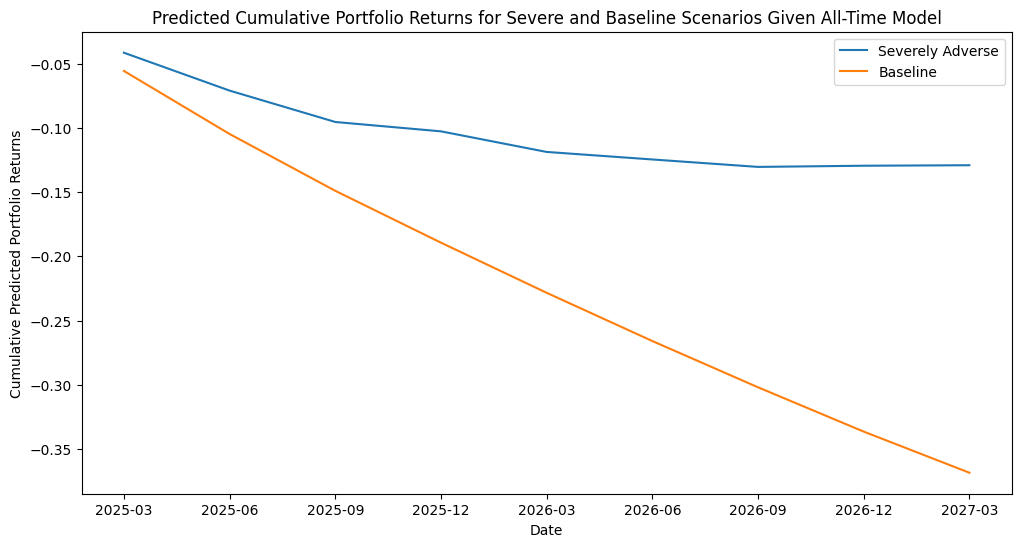

In [935]:
# plot the cumulative predicted portfolio returns for the severely adverse and baseline scenarios given all time model

cum_alltime_predicted_returns.plot(title='Predicted Cumulative Portfolio Returns for Severe and Baseline Scenarios Given All-Time Model', figsize=(12, 6), ylabel='Cumulative Predicted Portfolio Returns')

In [936]:
# Use stressed data to predict portfolio returns for the severely adverse and baseline scenarios

# Predict portfolio returns for the severely adverse scenario
predicted_returns_severe, predicted_factors_severe = predict_portfolio_returns(ffmodel, stressed_mkt_model, stressed_smb_model, stressed_hml_model, MEVs_severe)
predicted_returns_severe

# Predict portfolio returns for the baseline scenario
predicted_returns_baseline, predicted_factors_severe = predict_portfolio_returns(ffmodel, stressed_mkt_model, stressed_smb_model, stressed_hml_model, MEVs_baseline)
predicted_returns_baseline

# concat the predicted returns for the severely adverse and baseline scenarios
stressed_predicted_returns = pd.concat([predicted_returns_severe, predicted_returns_baseline], axis=1)
stressed_predicted_returns.columns = ['Severely Adverse', 'Baseline']


In [937]:
cum_stressed_predicted_returns = calculate_cumulative_returns(stressed_predicted_returns)
cum_stressed_predicted_returns

,Severely Adverse,Baseline
Date,,
2025-03,-0.151184,0.493702
2025-06,-0.215698,1.289859
2025-09,-0.223223,2.509658
2025-12,-0.403531,4.414380
2026-03,-0.340131,7.260496
2026-06,-0.370788,11.633453
2026-09,-0.368739,18.093353
2026-12,-0.404749,27.895471
2027-03,-0.415718,42.525651


<Axes: title={'center': 'Predicted Cumulative Portfolio Returns for Severe and Baseline Scenarios Given Stressed Model'}, xlabel='Date', ylabel='Cumulative Predicted Portfolio Returns'>

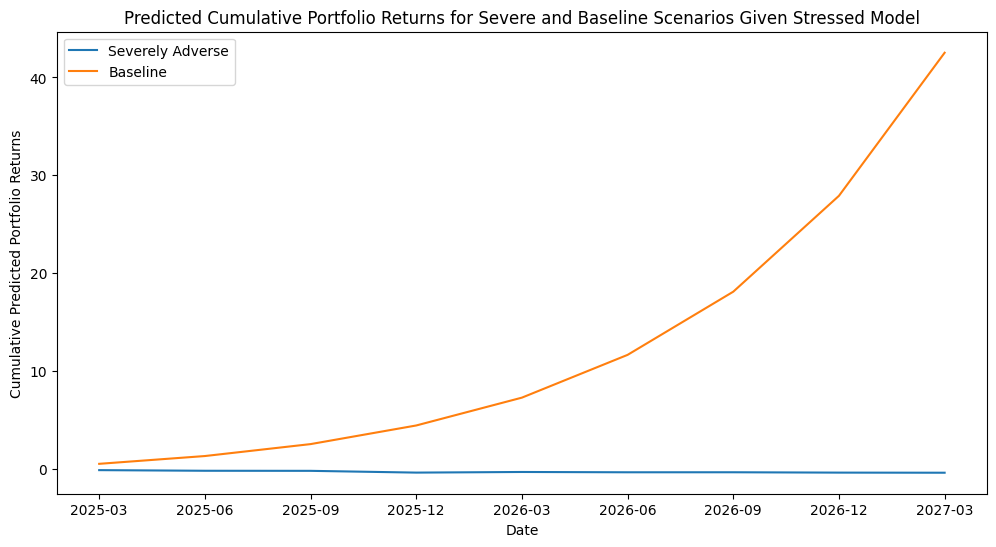

In [938]:
cum_stressed_predicted_returns.plot(title='Predicted Cumulative Portfolio Returns for Severe and Baseline Scenarios Given Stressed Model', figsize=(12, 6), ylabel='Cumulative Predicted Portfolio Returns')

# **Section 5: Construct your own model to stress test the performance of your portfolio**

In [939]:
data = pd.read_csv('F-F_Research_Data_5_Factors_2x3.csv')
data = data.set_index(data.columns[0])
data.index = pd.to_datetime(data.index, format='%Y%m')
data.index.rename('Date', inplace=True)
data = data[:"2023"]
data = data[['RMW', 'CMA']]

In [940]:
FF_factors = pd.read_excel('wrds_data.xlsx', sheet_name='returns', index_col=0)
FF_factors = FF_factors[['FAMA-FRENCH MARKET FACTOR', 'RISK-FREE RATE', 'FAMA-FRENCH SIZE FACTOR (SMB)', 'FAMA-FRENCH VALUE FACTOR (HML)', 'MOMENTUM FACTOR']]
FF_factors = FF_factors.rename(columns={'FAMA-FRENCH MARKET FACTOR': 'MKT', 'RISK-FREE RATE': 'RF','FAMA-FRENCH SIZE FACTOR (SMB)': 'SMB', 'FAMA-FRENCH VALUE FACTOR (HML)': 'HML', 'MOMENTUM FACTOR': 'UMD'})
FF_factors['MKT'] = FF_factors['MKT'] - FF_factors['RF']
FF_factors = FF_factors.drop(columns=['RF'])
FF_factors = FF_factors["1963-07":]


# Reset the indices of both DataFrames
test_reset = FF_factors.reset_index()
data_reset = data.reset_index(drop=True)

# Concatenate the DataFrames along the columns axis
FF_factors = pd.concat([test_reset, data_reset], axis=1)
FF_factors.set_index('Date', inplace=True)
# Display the updated DataFrame

/opt/anaconda3/envs/finm/lib/python3.12/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [941]:
# get FF factors and portfolio returns in one dataframe

FF_model = FF_factors.copy()
FF_model['portfolio'] = returns['portfolio']
FF_model = FF_model.dropna()

## Part 2 - repeat section 4 using new prediction model

In [942]:
# Regress portfolio returns on FF factors

import statsmodels.api as sm

X = FF_model[['MKT', 'SMB', 'HML', 'UMD', 'RMW', 'CMA']]
X = sm.add_constant(X)
Y = FF_model['portfolio']
ffmodel = sm.OLS(Y, X).fit()

# print results

print("FF5+1 model R^2:", ffmodel.rsquared)
ffmodel_regression_summary = pd.DataFrame([ffmodel.params, ffmodel.tvalues], index=['Betas', 't-values']).T
ffmodel_regression_summary

FF5+1 model R^2: 0.9043319773902342


,Betas,t-values
const,0.006299,6.871830
MKT,0.916544,40.642151
SMB,-0.304970,-7.252662
HML,0.065385,1.733310
UMD,-0.023009,-1.007057
RMW,-0.001208,-2.289309
CMA,0.000882,1.474503


In [943]:
# Adjust FF monthly returns to quarterly returns

FF_factors.reset_index(inplace=True)

# Extract quarter and aggregate the data
FF_factors['Date'] = pd.to_datetime(FF_factors['Date'])
FF_factors['Quarter'] = FF_factors['Date'].dt.to_period('Q')

# Calculate cumulative returns for each FF portfolio within each quarter
# Assuming monthly returns are given as percentages, so convert to decimals for compounding
FF_factors['MKT'] = FF_factors['MKT'] /100 + 1
FF_factors['SMB'] = FF_factors['SMB'] /100 + 1
FF_factors['HML'] = FF_factors['HML'] /100  + 1
FF_factors['UMD'] = FF_factors['UMD'] /100  + 1
FF_factors['RMW'] = FF_factors['RMW'] /100  + 1
FF_factors['CMA'] = FF_factors['CMA'] /100  + 1


# Aggregate cumulative returns by quarter using product to compound
quarterly_returns = FF_factors.groupby('Quarter').agg({
    'MKT': 'prod',
    'SMB': 'prod',
    'HML': 'prod',
    'UMD': 'prod',
    'RMW': 'prod',
    'CMA': 'prod'
}).reset_index()

# Convert back to percentage returns
quarterly_returns[['MKT', 'SMB', 'HML', 'UMD', 'RMW', 'CMA']] = (quarterly_returns[['MKT', 'SMB', 'HML', 'UMD', 'RMW', 'CMA']] - 1) * 100

quarterly_returns = quarterly_returns.set_index('Quarter')
quarterly_returns = quarterly_returns['1990':]
quarterly_returns.index = MEVs.index

quarterly_returns.head()

FF_MEVs = MEVs.merge(quarterly_returns, left_index=True, right_index=True, how='inner')

In [944]:
# Regress FF factors on MEVs

import statsmodels.api as sm

reg_models = []
factors = ['MKT', 'SMB', 'HML', 'UMD', 'RMW', 'CMA']
for factor in factors:
    model = sm.OLS(FF_MEVs[factor], sm.add_constant(FF_MEVs[['Real GDP growth', 'Real disposable income growth', 'CPI inflation rate', '3-month Treasury rate', '5-year Treasury yield', '10-year Treasury yield', 'Market Volatility Index (Level)']])).fit()
    reg_models.append(model)

mkt_model = reg_models[0]
smb_model = reg_models[1]
hml_model = reg_models[2]
umd_model = reg_models[3]
rmw_model = reg_models[4]
cma_model = reg_models[5]

# print results
print("MKT regression R^2:", mkt_model.rsquared)
print("SMB regression R^2:", smb_model.rsquared)
print("HML regression R^2:", hml_model.rsquared)
print("RMW regression R^2:", rmw_model.rsquared)
print("CMA regression R^2:", cma_model.rsquared)
print("UMD regression R^2:", umd_model.rsquared)

regression_summary = pd.DataFrame([mkt_model.params, mkt_model.tvalues,
                                   smb_model.params, smb_model.tvalues,
                                   hml_model.params, hml_model.tvalues,
                                   rmw_model.params, rmw_model.tvalues,
                                   cma_model.params, cma_model.tvalues,
                                   umd_model.params, umd_model.tvalues], 
                                   index=['MKT betas', 'MKT t-values', 'SMB betas', 'SMB t-values',
                                          'HML betas', 'HML t-values', 'RMW betas', 'RMW t-values', 
                                          'CMA betas', 'CMA t-values', 'UMD betas', 'UMD t-values']).T
regression_summary

MKT regression R^2: 0.14263072847689473
SMB regression R^2: 0.11015041676196358
HML regression R^2: 0.06919291678570594
RMW regression R^2: 0.0288168132958333
CMA regression R^2: 0.025353314479317768
UMD regression R^2: 0.037163553833001184


,MKT betas,MKT t-values,SMB betas,SMB t-values,HML betas,HML t-values,RMW betas,RMW t-values,CMA betas,CMA t-values,UMD betas,UMD t-values
const,0.080817,3.793438,0.015154,1.210375,0.040483,2.304782,-0.102954,-0.077489,-0.319430,-0.263494,0.000700,0.032197
Real GDP growth,0.001304,0.704501,-0.000053,-0.048413,-0.000869,-0.569436,0.048081,0.416447,-0.043744,-0.415243,0.002972,1.572392
Real disposable income growth,0.001254,1.260938,0.001057,1.808561,0.000391,0.476301,0.014171,0.228399,0.013440,0.237399,-0.000223,-0.219489
CPI inflation rate,0.000137,0.043468,-0.000507,-0.273913,0.000883,0.339837,-0.016971,-0.086341,0.084539,0.471376,-0.003149,-0.978603
3-month Treasury rate,-0.024945,-1.147650,-0.032754,-2.564200,-0.000053,-0.002979,0.144873,0.106876,0.120567,0.097480,0.007914,0.356644
5-year Treasury yield,0.009721,0.178545,0.013965,0.436459,-0.007787,-0.173463,-3.060747,-0.901430,2.291305,0.739581,0.007804,0.140400
10-year Treasury yield,-0.006217,-0.110846,0.021363,0.648165,0.030040,0.649655,1.883505,0.538517,-1.051803,-0.329584,-0.034358,-0.600050
Market Volatility Index (Level),-0.002717,-4.049941,-0.000553,-1.402945,-0.001277,-2.308983,0.039704,0.948970,0.039209,1.027085,0.000175,0.255183


In [945]:
stressed_data = pd.concat(
    [FF_MEVs.loc[start:end] for start, end in stressed_date_ranges]
)

stressed_reg_models = []
factors = ['MKT', 'SMB', 'HML', 'UMD', 'RMW', 'CMA']
for factor in factors:
    model = sm.OLS(stressed_data[factor], sm.add_constant(stressed_data[['Real GDP growth', 'Real disposable income growth', 'CPI inflation rate', '3-month Treasury rate', '5-year Treasury yield', '10-year Treasury yield', 'Market Volatility Index (Level)']])).fit()
    stressed_reg_models.append(model)

stressed_mkt_model = stressed_reg_models[0]
stressed_smb_model = stressed_reg_models[1]
stressed_hml_model = stressed_reg_models[2]
stressed_umd_model = stressed_reg_models[3]
stressed_rmw_model = stressed_reg_models[4]
stressed_cma_model = stressed_reg_models[5]

# print results
print("stressed MKT regression R^2:", stressed_mkt_model.rsquared)
print("stressed SMB regression R^2:", stressed_smb_model.rsquared)
print("stressed HML regression R^2:", stressed_hml_model.rsquared)
print("stressed RMW regression R^2:", stressed_rmw_model.rsquared)
print("stressed CMA regression R^2:", stressed_cma_model.rsquared)
print("stressed UMD regression R^2:", stressed_umd_model.rsquared)

regression_summary = pd.DataFrame([stressed_mkt_model.params, stressed_mkt_model.tvalues,
                                   stressed_smb_model.params, stressed_smb_model.tvalues,
                                   stressed_hml_model.params, stressed_hml_model.tvalues,
                                   stressed_rmw_model.params, stressed_rmw_model.tvalues,
                                   stressed_cma_model.params, stressed_cma_model.tvalues,
                                   stressed_umd_model.params, stressed_umd_model.tvalues],
                                   index=['stressed MKT betas', 'stressed MKT t-values',
                                          'stressed SMB betas', 'stressed SMB t-values',
                                          'stressed HML betas', 'stressed HML t-values',
                                          'stressed RMW betas', 'stressed RMW t-values',
                                          'stressed CMA betas', 'stressed CMA t-values',
                                          'stressed UMD betas', 'stressed UMD t-values']).T
regression_summary

stressed MKT regression R^2: 0.7023307703084825
stressed SMB regression R^2: 0.7176019746831155
stressed HML regression R^2: 0.47235510302680994
stressed RMW regression R^2: 0.4423934578622195
stressed CMA regression R^2: 0.4454740935243624
stressed UMD regression R^2: 0.6467631704676848


,stressed MKT betas,stressed MKT t-values,stressed SMB betas,stressed SMB t-values,stressed HML betas,stressed HML t-values,stressed RMW betas,stressed RMW t-values,stressed CMA betas,stressed CMA t-values,stressed UMD betas,stressed UMD t-values
const,0.130738,0.937940,-0.001516,-0.023787,0.150324,1.234230,12.408965,1.660991,1.689716,0.216695,0.059045,0.366199
Real GDP growth,-0.031849,-2.953250,-0.014483,-2.937135,-0.003538,-0.375403,0.804668,1.392125,1.083927,1.796656,0.041149,3.298595
Real disposable income growth,-0.008454,-1.572155,-0.005786,-2.353120,-0.001055,-0.224520,0.426283,1.479023,0.526687,1.750783,0.016106,2.589288
CPI inflation rate,0.005750,0.568257,0.003600,0.778125,-0.001456,-0.164624,-1.049258,-1.934678,-0.282562,-0.499163,-0.024851,-2.123105
3-month Treasury rate,-0.195170,-1.795327,-0.182453,-3.670619,0.072480,0.763029,10.596587,1.818664,11.255656,1.850805,0.250247,1.990028
5-year Treasury yield,0.264775,1.355153,0.206125,2.307283,-0.254621,-1.491422,-4.309311,-0.411506,-22.087506,-2.020777,-0.025689,-0.113664
10-year Treasury yield,0.085051,0.370821,-0.019385,-0.184843,0.283381,1.413997,-7.103927,-0.577882,13.043682,1.016585,-0.469160,-1.768339
Market Volatility Index (Level),-0.005690,-2.265730,-0.001370,-1.193059,-0.003722,-1.696161,-0.124844,-0.927461,0.045964,0.327154,0.000982,0.338057


In [946]:
import pandas as pd
import statsmodels.api as sm

def predict_portfolio_returns2(model_1, model_2, model_3, model_4, model_5, model_6, model_7, new_macro_data):
    """
    Predict the portfolio returns for each time period using a sequence of regression models.
    
    Parameters:
    - model_1: Fitted regression model for portfolio returns (dependent on MKT-RF, SMB, HML, UMD).
    - model_2: Fitted regression model for MKT-RF (dependent on macroeconomic variables).
    - model_3: Fitted regression model for SMB (dependent on macroeconomic variables).
    - model_4: Fitted regression model for HML (dependent on macroeconomic variables).
    - model_5: Fitted regression model for UMD (dependent on macroeconomic variables).
    - model_6: Fitted regression model for RMW (dependent on macroeconomic variables).
    - model_7: Fitted regression model for CMA (dependent on macroeconomic variables).
    - new_macro_data: pd.DataFrame - New dataset of macroeconomic variables (7 variables), with a time index.
    
    Returns:
    - predicted_returns_df: pd.DataFrame - DataFrame of predicted portfolio returns with the date index.
    - predicted_factors_df: pd.DataFrame - DataFrame of predicted Fama-French factors (MKT-RF, SMB, HML, UMD) for each period.
    """
    # Initialize lists to store the predicted factors
    predicted_MKT_RF = []
    predicted_SMB = []
    predicted_HML = []
    predicted_UMD = []
    predicted_RMW = []
    predicted_CMA = []

    # Loop through each row in the new macroeconomic dataset
    for index, row in new_macro_data.iterrows():
        # Add a constant to the row (to match the model's input structure)
        row_with_constant = sm.add_constant(row.to_frame().T, has_constant='add')

        # Predict the Fama-French factors for the current row of macroeconomic variables
        mkt_rf = model_2.predict(row_with_constant).iloc[0]
        smb = model_3.predict(row_with_constant).iloc[0]
        hml = model_4.predict(row_with_constant).iloc[0]
        umd = model_5.predict(row_with_constant).iloc[0]
        rmw = model_6.predict(row_with_constant).iloc[0]
        cma = model_7.predict(row_with_constant).iloc[0]

        # Append the predicted values to the respective lists
        predicted_MKT_RF.append(mkt_rf)
        predicted_SMB.append(smb)
        predicted_HML.append(hml)
        predicted_UMD.append(umd)
        predicted_RMW.append(rmw)
        predicted_CMA.append(cma)

    # Create a DataFrame of the predicted Fama-French factors
    predicted_factors_df = pd.DataFrame({
        'MKT_RF': predicted_MKT_RF,
        'SMB': predicted_SMB,
        'HML': predicted_HML,
        'UMD': predicted_UMD,
        'RMW': predicted_RMW,
        'CMA': predicted_CMA
    }, index=new_macro_data.index)

    # Add a constant to the predicted Fama-French factors DataFrame
    predicted_factors_with_constant = sm.add_constant(predicted_factors_df, has_constant='add')

    # Use the predicted Fama-French factors to predict the portfolio return for each time period
    predicted_portfolio_returns = model_1.predict(predicted_factors_with_constant)

    # Create a DataFrame for the predicted portfolio returns with the date index
    predicted_returns_df = pd.DataFrame(predicted_portfolio_returns, index=new_macro_data.index, columns=['Predicted Portfolio Return'])

    return predicted_returns_df, predicted_factors_df



In [947]:
# Use all-time data to predict portfolio returns for the severely adverse and baseline scenarios

# Predict portfolio returns for the severely adverse scenario
predicted_returns_severe, predicted_factors_severe = predict_portfolio_returns2(ffmodel, mkt_model, smb_model, hml_model, umd_model, rmw_model, cma_model,  MEVs_severe)
predicted_returns_severe

# Predict portfolio returns for the baseline scenario
predicted_returns_baseline, predicted_factors_severe = predict_portfolio_returns2(ffmodel, mkt_model, smb_model, hml_model, umd_model, rmw_model, cma_model, MEVs_baseline)
predicted_returns_baseline

# concat the predicted returns for the severely adverse and baseline scenarios
alltime_predicted_returns = pd.concat([predicted_returns_severe, predicted_returns_baseline], axis=1)
alltime_predicted_returns.columns = ['Severely Adverse', 'Baseline']
alltime_predicted_returns

cum_alltime_predicted_returns = calculate_cumulative_returns(alltime_predicted_returns)
cum_alltime_predicted_returns

,Severely Adverse,Baseline
Date,,
2025-03,-0.042681,-0.049300
2025-06,-0.070147,-0.093013
2025-09,-0.093927,-0.132625
2025-12,-0.101825,-0.169409
2026-03,-0.116615,-0.205681
2026-06,-0.121611,-0.240734
2026-09,-0.128131,-0.274966
2026-12,-0.125711,-0.307901
2027-03,-0.124986,-0.338974


<Axes: title={'center': 'Predicted Cumulative Portfolio Returns for Severe and Baseline Scenarios Given All-Time Model'}, xlabel='Date', ylabel='Cumulative Predicted Portfolio Returns'>

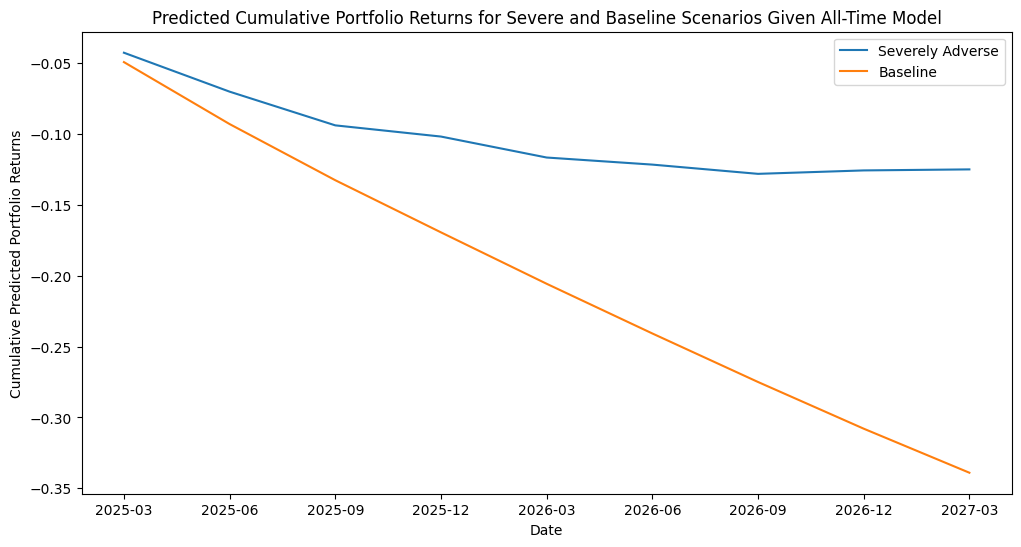

In [948]:
cum_alltime_predicted_returns.plot(title='Predicted Cumulative Portfolio Returns for Severe and Baseline Scenarios Given All-Time Model', figsize=(12, 6), ylabel='Cumulative Predicted Portfolio Returns')

In [949]:
# Use stressed data to predict portfolio returns for the severely adverse and baseline scenarios

# Predict portfolio returns for the severely adverse scenario
predicted_returns_severe, predicted_factors_severe = predict_portfolio_returns2(ffmodel, stressed_mkt_model, stressed_smb_model, stressed_hml_model, stressed_umd_model, stressed_rmw_model, stressed_cma_model, MEVs_severe)
predicted_returns_severe

# Predict portfolio returns for the baseline scenario
predicted_returns_baseline, predicted_factors_baseline = predict_portfolio_returns2(ffmodel, stressed_mkt_model, stressed_smb_model, stressed_hml_model, stressed_umd_model, stressed_rmw_model, stressed_cma_model, MEVs_baseline)
predicted_returns_baseline

# concat the predicted returns for the severely adverse and baseline scenarios
stressed_predicted_returns = pd.concat([predicted_returns_severe, predicted_returns_baseline], axis=1)
stressed_predicted_returns.columns = ['Severely Adverse', 'Baseline']
stressed_predicted_returns

cum_stressed_predicted_returns = calculate_cumulative_returns(stressed_predicted_returns)
cum_stressed_predicted_returns

,Severely Adverse,Baseline
Date,,
2025-03,-0.146572,0.499117
2025-06,-0.219462,1.308780
2025-09,-0.230219,2.555708
2025-12,-0.415408,4.518822
2026-03,-0.357336,7.477459
2026-06,-0.394375,12.055888
2026-09,-0.394388,18.886372
2026-12,-0.438745,29.332333
2027-03,-0.454862,45.099168


<Axes: title={'center': 'Predicted Cumulative Portfolio Returns for Severe and Baseline Scenarios Given Stressed Model'}, xlabel='Date', ylabel='Cumulative Predicted Portfolio Returns'>

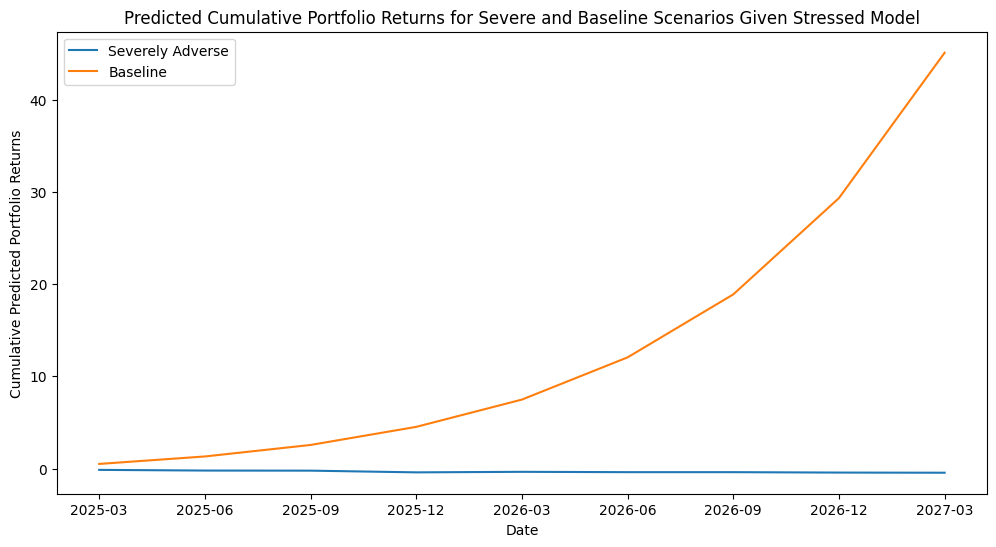

In [950]:
cum_stressed_predicted_returns.plot(title='Predicted Cumulative Portfolio Returns for Severe and Baseline Scenarios Given Stressed Model', figsize=(12, 6), ylabel='Cumulative Predicted Portfolio Returns')